# Dynamic Web Scrapping

## Abstract

- The aim of the project is to dynamically scrap a web page, store its data, make insightful visualizations and outline major findings.
- The data are taken from the [U.S. Department of Health and Human Services Office for Civil Rights](https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf), where instances of data breaches in the healthcare sector since 2009 are presented. Data breach can be defined as “the loss, theft, or unauthorized access to data containing sensitive personal and health information”.
- After pointing out that data leakages have primarily been caused by hacking (i.e., cyberattacks) via network servers and emails, we conclude that actors in the healthcare industry, especially healthcare providers (e.g., hospitals), are quite vulnerable to cybercriminals in terms of the absolute number of individuals exposed. Moreover, these cyberthreats have been rather augmenting over time. Therefore, much effort is required to cope with this problem, and cybersecurity standards should be raised in this sector for all actors.

## Web Scrapping

Let's start with scrapping the data from the [U.S. Department of Health and Human Services Office for Civil Rights](https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf) website.

In [1]:
# upload necessary libriaries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from datetime import datetime
import time
import json

def timer(func):
    """Decorate function by printing how long it has taken for a function to run.
        
    Input: function being decorated.

    Returns: decorated function."""
    def wrapper(*args, **kwargs):
        t_start = time.time()
        result = func(*args, **kwargs)
        hours = (time.time() - t_start) // 3600
        minutes = ((time.time() - t_start) % 3600) // 60
        seconds = ((time.time() - t_start) % 3600) % 60
        print('Function named "{}" took {:.0f} hours, {:.0f} minutes and {:.0f} seconds to be executed'.format(func.__name__, hours, minutes, seconds))        
        return result

    return wrapper

In [2]:
@timer
def web_scrap(URL, archive):
    
    """Parse through all pages of the website dynamically:
       
    Input: URL, archive (True if archive data is required, False if current data is required)
        
    Returns: source code of all pages of either current or archive data
    """
    
    # connect to the website 
    driver = webdriver.Chrome()
    wait = WebDriverWait(driver,15)
    driver.get(URL)
    
    # click 'Archive' button on the website if archive is required
    if archive == True:
        archive_button = driver.find_element(By.ID,"ocrForm:j_idt26") 
        archive_button.click()
        time.sleep(10)
    else:
        pass
    
    # set dict for source codes of each page parsed
    source_code = {}
    count = 1

    # loop through all pages accessible on the website
    while True:
        try:
            soup = BeautifulSoup(driver.page_source, 'lxml')
            source_code[count] = soup # add source code to the dict
            count += 1
            wait.until(EC.element_to_be_clickable((By.LINK_TEXT,str(count)))) # wait for accessibility of the link
            driver.find_element(By.LINK_TEXT,str(count)).click()
            time.sleep(10) # set waiting time to allow dowloading source code
        except Exception:
            break

    driver.quit()
    
    return source_code

In [3]:
@timer
def process_data(source_code, archive):
    
    """Process source code to bring each instance to the required format and create separate file:
       
    Input: source code taken from the web, archive (True if archive data is to be processed, False if current data is to be processed)
        
    Returns: dict with all instances recorded in the source code
    """
    
    # create dict for each breach
    breach_reports = {}
    count = 0
    
    # set additions to file names
    if archive == True:
        name = 'Archive'
    else:
        name = 'Current'

    # loop through source code to extract info of each breach
    for i in range(len(source_code.keys())):

        table_data = []

        # use tags to locate data to scrap
        for row in source_code[i+1].find_all('tr'):
            row_data = []
            for cell in row.find_all(['td', 'th']):
                row_data.append(cell.text.strip())
            if len(row_data) > 0:
                table_data.append(row_data)
        
        # take into account different formatting of the current and archive data in the source code
        if archive == True:
            headers = table_data[2]
            data = table_data[3:]
        else:
            headers = table_data[3]
            data = table_data[4:]
            
        data_dict = [dict(zip(headers, row)) for row in data] # set headers for each breach instance

        for i, breach_row in enumerate(data_dict):
            del breach_row['Expand All'] # delete unnecessary row
            try:
                breach_row['Individuals Affected'] = int(breach_row['Individuals Affected']) # convert to int
            except ValueError:
                breach_row['Individuals Affected'] = 0
            if breach_row['Business Associate Present'] == 'Yes': # convert to boolean
                breach_row['Business Associate Present'] = True
            else:
                breach_row['Business Associate Present'] = False
            breach_reports["Breach #" + str(count+1) + ' (' + name + ')'] = breach_row # give name to each breach
            # add custom metadata fields to the report dictionary object
            meta = {}
            meta["Date Scraped"] = str(datetime.now())
            meta["Category"] = "OCR_Breaches_" + name
            breach_reports["Breach #" + str(count+1) + ' (' + name + ')']['Metadata'] = meta
            count += 1
                
    return breach_reports

In [4]:
# run created functions for current data
current_source = web_scrap("https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf", False)
breach_reports = process_data(current_source, False)

Function named "web_scrap" took 0 hours, 1 minutes and 57 seconds to be executed
Function named "process_data" took 0 hours, 0 minutes and 0 seconds to be executed


In [20]:
# run created functions for archive data
archive_source = web_scrap("https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf", True)
breach_reports.update(process_data(archive_source, True))

Function named "web_scrap" took 0 hours, 8 minutes and 15 seconds to be executed
Function named "process_data" took 0 hours, 0 minutes and 1 seconds to be executed


We may also check if all breach instances dowloaded from the website are of the identical format.

In [21]:
def validate_json(breach):
    
    """Check if elements in a separate breach report are of required format:
       
    Input: breach instance
        
    Returns: True if all elements are of required format and False otherwise with the first field unmatched
    """

    # Define all expected fields and their types as a dictionary
    expected_fields = {
        "Name of Covered Entity": str,
        "State": str,
        "Covered Entity Type": str,
        "Individuals Affected": int,
        "Breach Submission Date": str,
        "Type of Breach": str,
        "Location of Breached Information": str,
        "Business Associate Present": bool, 
        'Web Description': str,
        'Metadata': dict
    } 
    # Verify if fields are of required format
    for field_name, field_type in expected_fields.items():
        if not (field_name in breach and isinstance(breach[field_name], field_type)):
            print('\033[1;91m' + 'First error in the following field: ' + '\033[0m', field_name)
            return False
    return True
    
# run function on all separate breach instances to see results 
for i in breach_reports.keys():
    validate_json(breach_reports[i])

## Visualizations

Let's start our analysis with the geographic distribution of breaches recorded in the created dataset.

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

from urllib.request import urlopen
with urlopen('https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_hash.json') as f:
    correspondence = json.load(f)
    
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as f:
    geodata = json.load(f)
    
rows = len(geodata['features'])
for i in range(rows):
    for j in correspondence:
        if geodata['features'][i]['properties']['name'].lower() == correspondence[j].lower():
            geodata['features'][i]['properties']['state'] = j
            
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.io as pio

data = pd.DataFrame().from_dict(breach_reports, orient='index')
data['name'] = data['State'].map(correspondence)
data_agg = data.groupby(['name','State']).agg(np.sum).reset_index()
data_agg['Number of Breaches'] = data.groupby(['name','State']).size().reset_index()[0]

fig = px.choropleth_mapbox(data_agg, geojson=geodata, color='Number of Breaches', title='Geographic Distribution of Breaches since 2009',
                           color_continuous_scale="Viridis", 
                           locations="State", featureidkey="properties.state", 
                           center={"lat": 40.7128, "lon": -94.0060}, opacity=0.8, hover_name="name",
                           hover_data={'State':False, 'Business Associate Present':True, 'Number of Breaches':True, 'Individuals Affected':True},
                           mapbox_style="carto-positron", zoom=2.5)
    
fig.show()

The map clearly indicates that the largest amount of breaches since 2009 happened in California, Florida, and also in New York, while Texas and Illinois have also been affected way more as compared to the rest of the states. This might be related to population density and the level of industrial development. On the other hand, if we consider the number of individuals affected by those breaches then Indiana would come first, which is in large part due to one massive incident involving insurance company Anthem Inc. (now called Elevance Health Inc.) in 2015, when hackers obtained data on 78.8 million members and employees.

As our next step let's explore the overall temporal dynamics of breaches.

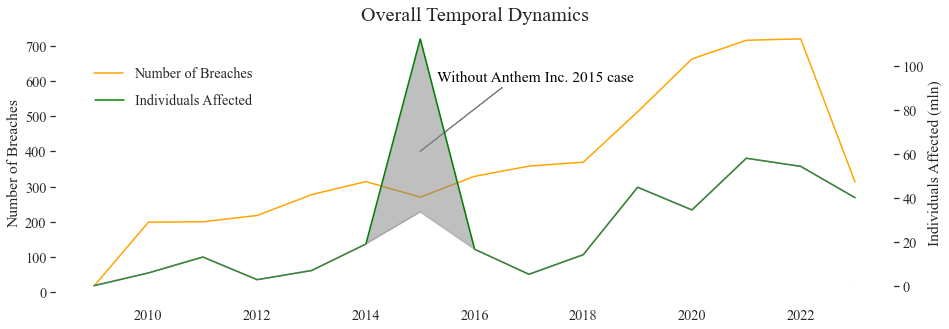

In [37]:
toggle_code()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(palette='summer')
colors = ["green", "orange"]
sns.set_palette(sns.color_palette(colors))
sns.set_style("white")
sns.set(rc={'figure.figsize':(15,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color': 'white', 'font.family':'Times New Roman'}, font_scale=1.3) 

data['Year'] = pd.to_datetime(pd.to_datetime(data['Breach Submission Date']).dt.strftime('%Y')).dt.year
temporal_dynamics = data.groupby(['Year']).agg(np.sum).reset_index()
temporal_dynamics['Number of Breaches'] = data.groupby(['Year']).size().values
temporal_dynamics['Individuals Affected (mln)'] = temporal_dynamics['Individuals Affected']/1000000
temporal_dynamics_no_spike = data[(data['Year']!=2015) | (data['Name of Covered Entity']!='Anthem Inc.')].groupby(['Year']).agg(np.sum).reset_index()
temporal_dynamics_no_spike['Individuals Affected (mln)'] = temporal_dynamics_no_spike['Individuals Affected']/1000000
ax1 = sns.lineplot(data=temporal_dynamics, x="Year", y="Number of Breaches", color='orange')
ax2 = plt.twinx()
ax2 = sns.lineplot(data=temporal_dynamics, x="Year", y="Individuals Affected (mln)", ax=ax2, color='green')
ax3 = sns.lineplot(data=temporal_dynamics_no_spike, x="Year", y="Individuals Affected (mln)", ax=ax2, color='gray', alpha=0.5)
ax1.legend(['Number of Breaches'], edgecolor='white', bbox_to_anchor=(0.25, 0.9))
ax2.legend(['Individuals Affected'], edgecolor='white', bbox_to_anchor=(0.25, 0.8))
ax1.text(2015.3, 600, "Without Anthem Inc. 2015 case", color='black')
ax1.arrow(2015, 400, 1.5, 180, width = 0.01, color='gray')
ax2.grid(False)
ax1.set_xlabel('')
plt.fill_between(temporal_dynamics['Year'], temporal_dynamics['Individuals Affected (mln)'], color='gray', alpha=0.5)
plt.fill_between(temporal_dynamics_no_spike['Year'], temporal_dynamics_no_spike['Individuals Affected (mln)'], color='white')
plt.title("Overall Temporal Dynamics", fontdict={'fontsize': 20})
plt.show()

There have been an upward trend in the number of breaches since 2009, though with some fluctuations. On the other hand, the amount of affected individuals has rather been unstable with slight upward trend. The spike in their number happened in 2015 is quite noteworthy, since at that time hackers turned to healthcare sector from retail and financial industry and some of the largest breaches happened at that time - that of Anthem Inc, Premera Blue Cross, and Excellus, when around 100 mln individuals were affected. When excluding Anthem Inc case as the largest outlier in our data, the upward trend becomes more identifiable. It is also worth mentioning that since the start of 2023 the number of breaches is lower, since the year has not ended yet. In addition, report of actual data is usually lagging - according to an IBM survey, it takes about 55 days for healthcare organizations to detect a data breach.

In [24]:
toggle_code()

largest_breaches = data.sort_values(by='Individuals Affected', ascending=False)
largest_breaches.head(5)[['Name of Covered Entity','Covered Entity Type','Individuals Affected','Breach Submission Date']]

,Name of Covered Entity,Covered Entity Type,Individuals Affected,Breach Submission Date
Breach #3317 (Archive),Anthem Inc.,Health Plan,78800000,02/13/2015
Breach #1784 (Archive),"Optum360, LLC",Business Associate,11500000,07/01/2019
Breach #3294 (Archive),Premera Blue Cross,Health Plan,11000000,03/17/2015
Breach #1762 (Archive),Laboratory Corporation of America Holdings dba...,Healthcare Provider,10251784,07/13/2019
Breach #3153 (Archive),"Excellus Health Plan, Inc.",Health Plan,9358891,09/09/2015


In [26]:
toggle_code()

data[(data['Year']==2015) & (data['Name of Covered Entity']=='Anthem Inc.')]['Web Description'].values[0]

'Anthem, Inc. has agreed to pay $16 million to the U.S. Department of Health and Human Services, Office for Civil Rights (OCR) and take substantial corrective action to settle potential violations of the Health Insurance Portability and Accountability Act (HIPAA) Privacy and Security Rules after a series of cyberattacks led to the largest U.S. health data breach in history and exposed the electronic protected health information of almost 79 million people.\n\nOn March 13, 2015, Anthem filed a breach report with the HHS Office for Civil Rights detailing that, on January 29, 2015, they discovered cyber-attackers had gained access to their IT system via an undetected continuous and targeted cyberattack for the apparent purpose of extracting data, otherwise known as an advanced persistent threat attack.  After filing their breach report, Anthem discovered cyber-attackers had infiltrated their system through spear phishing emails sent to an Anthem subsidiary after at least one employee resp

The table above illustrates that among 5 largest breaches recorded since 2009 three happened in 2015 and two in 2019. In addition, the description of the largest breach is also shown.

After having got the overall picture, let's dive into the average size of data breaches in terms of individuals affected - this numbers will show us the potential adverse effects.

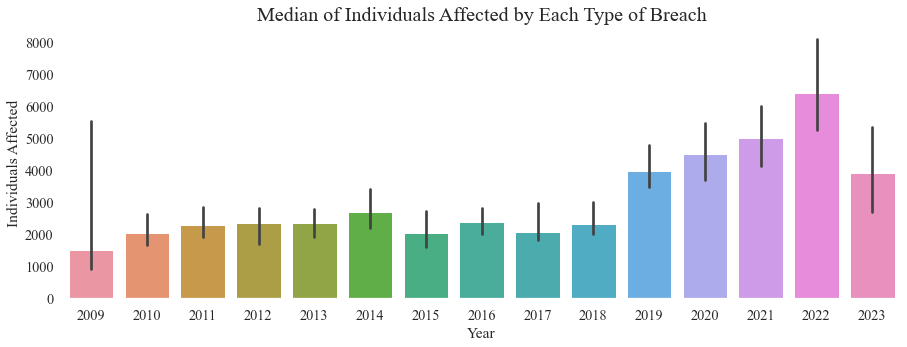

In [27]:
toggle_code()

sns.barplot(data, y='Individuals Affected', x='Year', estimator='median')
plt.title("Median of Individuals Affected by Each Type of Breach", fontdict={'fontsize': 20})
plt.show()

The distribution of affected individuals is skewed to the right with many large outliers, as reflected by the large confidence interval of the median estimates, however a clear upward trend over time can be observed (maximum value of around 6000 is observed in 2022).

In [28]:
toggle_code()

data['Submission Date'] = pd.to_datetime(pd.to_datetime(data['Breach Submission Date']).dt.strftime('%m/%d/%Y'))
scatter_plot = data[(data['Year']!=2015) | (data['Name of Covered Entity']!='Anthem Inc.')] # remove larget outlier

fig = px.scatter(scatter_plot, title='Individuals Affected per Breach over Time',
    x='Submission Date',
    y='Individuals Affected',
    color='Year', size='Individuals Affected',
    color_continuous_scale=px.colors.sequential.Viridis, hover_name=scatter_plot['Name of Covered Entity'],
    hover_data={'Year':False, 'Type of Breach':True, 'Location of Breached Information':True}
)

fig.update_layout(plot_bgcolor='white', width=800, height=500)

fig.show()

The number of affected individuals per breach has been increasing since 2009 (the Anthem Inc. case is excluded for visualization purposes), meaning that the potential harm of a single cyberattack may also increase in the observable future. However, the majority of breaches have rather been smaller in magnitude, as reflected by the size of bubbles on the plot above.

Next, we consider the most frequent types of breaches recorded in our dataset.

In [29]:
toggle_code()

breach_types = data.groupby(['Year', 'Type of Breach']).agg(np.sum).reset_index()
breach_types['Number of Breaches'] = data.groupby(['Year', 'Type of Breach']).size().values
breach_types = breach_types.sort_values(by='Number of Breaches', ascending=False)

fig = px.area(breach_types[breach_types['Type of Breach'].isin(data['Type of Breach'].value_counts().index[:6])], 
              y="Number of Breaches", x="Year", color="Type of Breach", title="Total Number of Breaches Over Time by Type")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.update_xaxes(tickangle=45)
fig.show()

The plot shows us that Hacking / IT incidents (direct cyberattack) have happened most often since 2009, while second most often type of incidents has been Unauthorized Access / Disclosure (often caused by employees' misdirection of information) and Theft (laptops or thumb drives are left in public places or stolen). The number of other categories is rather miniscule. It is also noteworthy that many incidents might have also been detected many years after their actual date, while others remained totally unnoticed, especially in the early years, when healthcare organizations were less able to detect them. Finally, regarding temporal dynamics of each type of incidences, we may also notice that hacking is becoming almost exponentially more prevalent, unauthorized access is also growing in number, while theft and unauthorized access are decreasing in their frequency.

However, besides the count of breache types, the total number of affected individuals by those types of incidents might also be informative.

In [30]:
toggle_code()

fig = px.bar(breach_types[breach_types['Type of Breach'].isin(data['Type of Breach'].value_counts().index[:6])], y="Individuals Affected", x="Year", color="Type of Breach", title="Total Number of Affected Individuals Over Time by Type of Breach")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.show()

Evidently, Hacking / IT Incident is still the most frequent type observed in our data in terms of individuals affected and has been increasing over time, meaning that in the healthcare sector it is the preeminent threat. The huge value for 2015 can be explained by the largest outlier in our dataset (i.e., Anthem Inc. case), which we have already discussed above.

In [31]:
toggle_code()

breach_types_no_outlier = data[data['Individuals Affected']<50000]

fig = px.box(breach_types_no_outlier[breach_types_no_outlier['Type of Breach'].isin(breach_types_no_outlier['Type of Breach'].value_counts().index[:6])], 
             x="Type of Breach", y="Individuals Affected", title='Distribution of Individuals Affected by Breach Type')
fig.update_layout(plot_bgcolor='white', width=800, height=500)
fig.show()

This point can further be illustrated by examining the distribution and range of affected individuals by type of breach. Even after having excluded extreme values of over 50k in terms of affected individuals per instance of data leakage, we can see how many outliers are still there for the Hacking / IT Incident category over the whole observation period, not to mention its highest median value. This signifies how dangerous cyberattacks are, having the potential to lead to the most extreme situations and complicating lives of many people, as compared to other types of breaches. Unauthorized access and theft come second in this respect.

Further, let's check what entity types, as well as locations of breaches, are covered by our dataset.

In [32]:
toggle_code()

covered_types = data.groupby(['Year', 'Covered Entity Type']).agg(np.sum).reset_index()
covered_types['Number of Breaches'] = data.groupby(['Year', 'Covered Entity Type']).size().values
covered_types = covered_types[covered_types['Covered Entity Type']!='']

fig = px.area(covered_types, y="Number of Breaches", x="Year", color="Covered Entity Type", title="Covered Entity Type vs Number of Breaches over Time")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.update_xaxes(tickangle=45)
fig.show()

The majority of the breaches in our dataset have been reported by healthcare providers, while business associates and health plans constitute a minority. Moreover, the number of incidences for all these categories has been increasing over the years since 2009.

In [33]:
toggle_code()

covered_types = scatter_plot.groupby(['Type of Breach', 'Covered Entity Type']).agg(np.sum).reset_index()
covered_types['Number of Breaches'] = scatter_plot.groupby(['Type of Breach', 'Covered Entity Type']).size().values
covered_types = covered_types[covered_types['Type of Breach'].isin(data['Type of Breach'].value_counts().index[:6])]
covered_types = covered_types[covered_types['Covered Entity Type']!=''].sort_values(by='Number of Breaches', ascending=False)

fig = px.bar(covered_types, y="Individuals Affected", x="Covered Entity Type", color="Type of Breach", title="Covered Entity Types vs Individuals Affected by Breaches' Type")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.show()

In terms of data breaches magnitude healthcare providers (e.g., hospitals) have suffered primarily from hacker attacks, while the rest could be attributed to theft and unauthorized access. The same picture can be observed with regard to business associates and health plans, meaning that special attention should be paid by these entities towards risks posed by the above-mentioned cyber threats.

In [34]:
toggle_code()

location_types = data.groupby(['Year', 'Location of Breached Information']).agg(np.sum).reset_index()
location_types['Number of Breaches'] = data.groupby(['Year', 'Location of Breached Information']).size().values
location_types = location_types.sort_values(by='Number of Breaches', ascending=False)
fig = px.area(location_types[location_types['Location of Breached Information'].isin(data['Location of Breached Information'].value_counts().index[:8])], 
             y="Number of Breaches", x="Year", color="Location of Breached Information", title="Locations of Breached Information vs Number of Breaches over Time")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.update_xaxes(tickangle=45)
fig.show()

There is no wonder that in terms of location of breaches, most of them have occured on the network server and increased over time, since hacking is the major breach category observed in the healthcare sector. Thus, the network server is the most evident path to steal data for hackers - more precautionary actions regarding this path should be taken. Emails and paper/films come second in this respect with much difference from the former in the number of instances, but they have also been increasing over time in the number of cases. The rest are way less significant in terms of breaches' frequency, though electronic medical records have shown a surge in data leakage instances since the pandemic times.

In [35]:
toggle_code()

location_types = scatter_plot.groupby(['Type of Breach', 'Location of Breached Information']).agg(np.sum).reset_index()
location_types['Number of Breaches'] = scatter_plot.groupby(['Type of Breach', 'Location of Breached Information']).size().values
location_types = location_types[location_types['Type of Breach'].isin(data['Type of Breach'].value_counts().index[:6])]
location_types = location_types.sort_values(by='Number of Breaches', ascending=False)

fig = px.bar(location_types[location_types['Location of Breached Information'].isin(data['Location of Breached Information'].value_counts().index[:8])],
             y="Individuals Affected", x="Location of Breached Information", color="Type of Breach", title="Locations of Breached Information vs Individuals Affected by Breaches' Types")
fig.update_layout(plot_bgcolor='white', xaxis = dict(tickmode = 'linear', tick0 = 1), width=800, height=500)
fig.show()

As it could have been expected, the largest data leakages have been primarily carried out via network servers and emails by hacking and to a much lesser extent by other types in terms of individuals affected. It is also noteworthy that theft has been a significant breach category for laptops and desktop computers. 

## Concluding Remarks

Electronic records of patients' private data have been used more and more in the healthcare sector since 2010, when hospitals were taking advantage of the related federal incentive programs (billions of dollars were invested). Moreover, this process has been accelerated even more at the time the COVID-19 pandemic started in 2020, when the use of network- and internet-connected devices in this sector has been augmented. Hospitals’ dependency on third-party technology also makes them more vulnerable, because they don’t have total control over the security of third-party tool. Therefore, it is no wonder that data breaches recorded on the Privacy Rights Clearinghouse database between 2015 and 2019 show that around 77% of all recorded data breaches have been in the healthcare sector, meaning that breaches in this sector are way more frequent than in the education, finance, retail, and government sectors. Moreover, the majority of such breaches in this sector have been hacking (i.e., cyberattacks) mostly undertaken via network servers. There are several reasons behind it - higher value on the black market (healthcare data can be used by criminals longer than financial), the sensitivity of the data for healthcare providers (hence it can be ransomed) and larger databases of healthcare organizations. 

Finally, on the one hand, healthcare is considered as 1 out of 16 critical infrastructure sectors, and cyberattacks can literally put [people's lives at risk](https://www.wsj.com/articles/ransomware-hackers-hospital-first-alleged-death-11633008116?mod=article_relatedinline). On the other hand, the fines imposed on healthcare organization for breaches occurred are also enourmous (e.g.,  Anthem paid $16 million to settle the 2015 data breach). Therefore, cybersecurity is extremely important for this sector, and the US authorities are very concerned regarding this issue, rasing the bar of minimum requirements there.